In [1]:
# SVM
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# CIFAR 10 data loading and preprocessing

cifar10_dir = '/home/aniket/Downloads/CS231n/assignment1/cs231n/datasets/cifar-10-batches-py/'

# cleaning up variable to prevent loading data multiple times
try:
    del X_train, y_train
    del X_test, y_test
    print('clear previously loaded data')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

#As a sanity check, we print the total output size of training and test data
print('training data size is :',X_train.shape)
print('training label size :',y_train.shape)
print('testing data size :',X_test.shape)
print('testing label size :',y_test.shape)

training data size is : (50000, 32, 32, 3)
training label size : (50000,)
testing data size : (10000, 32, 32, 3)
testing label size : (10000,)


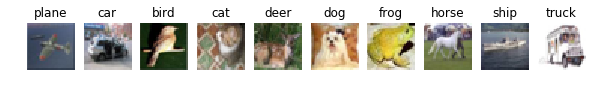

In [3]:
# visualize some of examples from dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 1
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i ,idx in enumerate(idxs):
        plt_idx = i * num_classes + y +1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# preprocessing : reshape the image data into rows

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_val, (X_val.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('training data shape', X_train.shape)
print('validation data shape', X_val.shape)
print('testing data shape', X_val.shape)
print('development data shape', X_dev.shape)

training data shape (49000, 3072)
validation data shape (1000, 3072)
testing data shape (1000, 3072)
development data shape (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


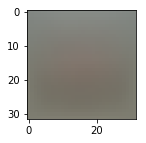

In [6]:
# Zero-Centering the data
# first compute the mean image
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print few of them
plt.figure(figsize=(2,2))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the image
plt.show()

In [7]:
# subtract the mean image from training and testing data
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image
X_dev -= mean_image

In [8]:
# append the bias dimension of ones (i.e bias trick) so that 
# SVM only optimize weight matrix W
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [9]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1  # note delta = 1
      if margin > 0:
        loss += margin

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)

  # Compute the gradient of loss with respect to Weight parameter
    
  h = 0.00001
  it = np.ndidtr(X, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.mul_index
    old_value = X[ix]
    X[ix] = old_value + h
    fxh = loss + h
    X[ix] = old_value
    
    # compute the partial derivative
    grad[ix] = (fxh - loss)/h
    
    it.iternext()
    
    return dw

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################


  return loss, dW
                                                  

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

AttributeError: module 'numpy' has no attribute 'ndidtr'